# Model Exploration

In [10]:
import numpy as np
from skneuromsi.sweep import ProcessingStrategyABC

HC_bias_a = np.array(
    [
        -5.21640112246667,
        -4.18706601266667,
        -3.13696911613333,
        -2.09924748133333,
        1.35796414540000,
        3.07563797893333,
        3.81842299133333,
        3.35914483333333,
    ]
)

## TEMPORAL DATA

temporal_dis = (
    np.array(
        [
            -0.7,
            -0.5,
            -0.3,
            -0.25,
            -0.2,
            -0.15,
            -0.1,
            -0.08,
            -0.05,
            -0.02,
            -0.01,
            #    0.0,
            0.01,
            0.02,
            0.05,
            0.08,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.5,
            0.7,
        ]
    )
    * 1000
)

temporal_causes_data = np.array(
    [
        0.03154762,
        0.03214286,
        0.07619048,
        0.19699793,
        0.30345238,
        0.50193093,
        0.72754579,
        0.82582418,
        0.90882784,
        0.93468864,
        0.97271062,
        #    0.97710623,
        0.95398352,
        0.94500916,
        0.94871795,
        0.94787546,
        0.92052078,
        0.87787546,
        0.75857143,
        0.51714286,
        0.33121212,
        0.05779221,
        0.02836439,
    ]
)

HC_pro_com = np.array(
    [
        0.367025484375000,
        0.682562911541667,
        0.822405755208334,
        0.876760716875000,
        0.863113007208333,
        0.809197201583333,
        0.649743997500000,
        0.321256356083333,
    ]
)


class CausesProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        causes = result.causes_
        del result._nddata
        return causes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float16)

In [ ]:
import matplotlib.pyplot as plt
from skneuromsi.sweep import ParameterSweep
from skneuromsi.bayesian import Kording2007
from skneuromsi.neural import Paredes2022

# MODEL SETUP
model_kording = Kording2007(position_range=(0, 90), position_res=1)
model_paredes = Paredes2022(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 100)
)

causal_model_paredes = Paredes2022(
    neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 150)
)

## SWEEP SETUP
dis = np.array([-24, -12, -6, -3, 3, 6, 12, 24])
bias_data = np.abs(HC_bias_a) / np.abs(dis)
causes_data = HC_pro_com

## Auditory Bias

In [190]:
def compute_estimated_position(modes_values):
    max_dim_index = modes_values.index.get_level_values("times").max()
    max_dim_values = modes_values.xs(max_dim_index, level="times").values.T[0]
    estimated_dim_position = max_dim_values.argmax()
    return estimated_dim_position


def compute_bias(estimated_auditory_position, auditory_position, visual_position):
    bias = np.abs(estimated_auditory_position - auditory_position) / np.abs(
        auditory_position - visual_position
    )
    return bias


def compute_bias_from_sweep(sweep_res, a_position=45, v_position=51, mode="auditory"):
    sweep_bias = []
    for res in sweep_res:
        estimated_auditory_position = compute_estimated_position(
            res.get_modes(include=mode)
        )
        bias = compute_bias(
            estimated_auditory_position=estimated_auditory_position,
            auditory_position=a_position,
            visual_position=v_position,
        )
        sweep_bias.append(bias)
    return sweep_bias

Sweeping 'p_common':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'visual_sigma':   0%|          | 0/5 [00:00<?, ?it/s]

/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(.

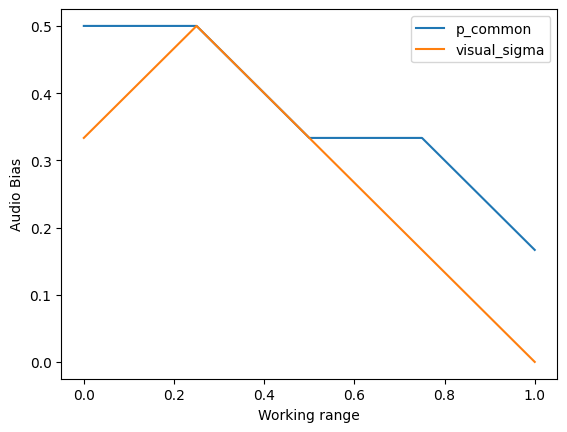

In [192]:
p_common_range = np.linspace(0, 1, 5)
visual_sigma_range = np.linspace(0.125, 6.5, 5)

sp_kording_p_common = ParameterSweep(
    model=model_kording,
    target="p_common",
    repeat=1,
    n_jobs=1,
    range=p_common_range,
)

sp_kording_visual_sigma = ParameterSweep(
    model=model_kording,
    target="visual_sigma",
    repeat=1,
    n_jobs=1,
    range=visual_sigma_range,
)

res_kording_p_common = sp_kording_p_common.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.490e01,
    visual_sigma=2.171e01,
    prior_mu=4.069e01,
    prior_sigma=5.277e00,
    noise=False,
)

res_kording_visual_sigma = sp_kording_visual_sigma.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.490e01,
    prior_mu=4.069e01,
    prior_sigma=5.277e00,
    noise=False,
)

res_kording_p_common_bias = compute_bias_from_sweep(res_kording_p_common)
res_kording_visual_sigma_bias = compute_bias_from_sweep(res_kording_visual_sigma)

plt.plot(p_common_range, res_kording_p_common_bias, label="p_common")
plt.plot(p_common_range, res_kording_visual_sigma_bias, label="visual_sigma")
plt.xlabel("Working range")
plt.ylabel("Audio Bias")
plt.legend()

Sweeping 'lateral_excitation':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'cross_modal_weight':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'feedforward_weight':   0%|          | 0/5 [00:00<?, ?it/s]

Sweeping 'feedback_weight':   0%|          | 0/5 [00:00<?, ?it/s]

/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for gname, group in xa.groupby(dim_name):
/home/renato/scikit-neuromsi/skneuromsi/core/ndresult/result.py:493: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(.

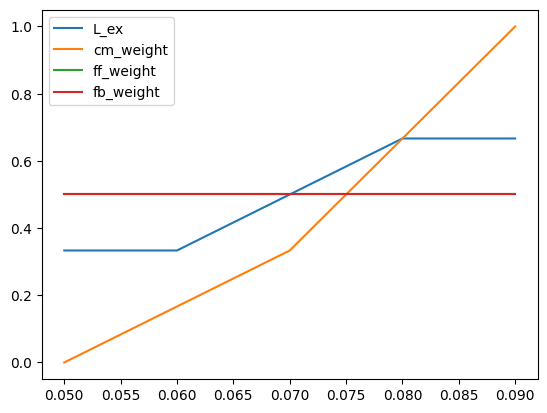

In [193]:
lex_range = np.linspace(0.5, 3, 5)
cm_range = np.linspace(0.05, 0.09, 5)
ff_range = np.linspace(0, 2.5, 5)
fb_range = np.linspace(0, 1, 5)

sp_paredes_lex = ParameterSweep(
    model=model_paredes,
    target="lateral_excitation",
    repeat=1,
    n_jobs=-2,
    range=lex_range,
)

sp_paredes_cm = ParameterSweep(
    model=model_paredes,
    target="cross_modal_weight",
    repeat=1,
    n_jobs=-2,
    range=cm_range,
)

sp_paredes_ff = ParameterSweep(
    model=model_paredes,
    target="feedforward_weight",
    repeat=1,
    n_jobs=-2,
    range=ff_range,
)

sp_paredes_fb = ParameterSweep(
    model=model_paredes,
    target="feedback_weight",
    repeat=1,
    n_jobs=-2,
    range=fb_range,
)

res_paredes_lex = sp_paredes_lex.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_cm = sp_paredes_cm.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_ff = sp_paredes_ff.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_fb = sp_paredes_fb.run(
    auditory_position=45,
    visual_position=45 + dis[5],
    auditory_sigma=2.000e01,
    visual_sigma=1.854e01,
    auditory_intensity=1.113e00,
    visual_intensity=7.728e00,
    noise=False,
    auditory_soa=None,
    auditory_stim_n=1,
    visual_stim_n=1,
    auditory_duration=100,
    visual_duration=100,
    auditory_onset=0,
    visual_onset=0,
)

res_paredes_lex_bias = compute_bias_from_sweep(res_paredes_lex)
res_paredes_cm_bias = compute_bias_from_sweep(res_paredes_cm)
res_paredes_ff_bias = compute_bias_from_sweep(res_paredes_ff)
res_paredes_fb_bias = compute_bias_from_sweep(res_paredes_fb)

plt.plot(cm_range, res_paredes_lex_bias, label="L_ex")
plt.plot(cm_range, res_paredes_cm_bias, label="cm_weight")
plt.plot(cm_range, res_paredes_ff_bias, label="ff_weight")
plt.plot(cm_range, res_paredes_fb_bias, label="fb_weight")
plt.legend()

## Spatial Causal Inference

In [ ]:
## Take gaussian fit function from skneuromsi tests (stim location)